# EDA: VADER Baseline on Sample Financial Texts

## Imports & Paths

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Notebook bootstrap: make `src` and data paths work consistently ---
import sys
from pathlib import Path

# If the notebook is in project/notebooks/, project_root is parent of CWD
# If you started from project root, this still resolves correctly.
project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent

# Ensure `src/` is importable
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.preprocess.text_cleaner import clean_text
from src.models.sentiment import score_vader

# Data paths (absolute from project_root, no more ../ headaches)
RAW = project_root / "data/raw/synthetic_fintext.csv"
OUT = project_root / "data/processed/sentiment_vader_scored.csv"

print("Project root:", project_root)
print("RAW exists:", RAW.exists())

Project root: /Users/jkim/Projects/stock-sentiment-analyzer
RAW exists: True


## Load & Clean

In [6]:
df = pd.read_csv(RAW, parse_dates=["timestamp"])
df["text_clean"] = df["text"].map(clean_text)
df.head()

,timestamp,ticker,source,text,label_bucket,text_clean
0,2025-08-16 00:29:21,TSLA,news,IMO: TSLA massive beat 😤 #AI DYOR,positive,imo tsla massive beat ai dyor
1,2025-08-16 01:13:21,AAPL,news,$AAPL @jimcramer Breaking: AAPL waiting for ea...,neutral,aapl breaking aapl waiting for earnings dyor
2,2025-08-16 02:06:21,SOFI,news,$SOFI @barronsonline FYI: SOFI sector rotation...,neutral,sofi fyi sofi sector rotation earnings
3,2025-08-16 02:17:21,AAPL,reddit,$AAPL Update: AAPL profit warning ❌,negative,aapl update aapl profit warning
4,2025-08-16 03:28:21,TSLA,twitter,$TSLA Breaking: TSLA strong demand ✅ #stocks,positive,tsla breaking tsla strong demand stocks


## Score with VADER

In [7]:
# keep both columns with distinct names
df = pd.read_csv(RAW, parse_dates=["timestamp"])
df["text_clean"] = df["text"].map(clean_text)

# score on the cleaned text
scored = score_vader(df, text_col="text_clean")
scored[["ticker","source","text","text_clean","neg","neu","pos","compound"]].head()

,ticker,source,text,text_clean,neg,neu,pos,compound
0,TSLA,news,IMO: TSLA massive beat 😤 #AI DYOR,imo tsla massive beat ai dyor,0.000,1.000,0.000,0.0000
1,AAPL,news,$AAPL @jimcramer Breaking: AAPL waiting for ea...,aapl breaking aapl waiting for earnings dyor,0.000,1.000,0.000,0.0000
2,SOFI,news,$SOFI @barronsonline FYI: SOFI sector rotation...,sofi fyi sofi sector rotation earnings,0.000,0.735,0.265,0.2023
3,AAPL,reddit,$AAPL Update: AAPL profit warning ❌,aapl update aapl profit warning,0.289,0.361,0.349,0.1280
4,TSLA,twitter,$TSLA Breaking: TSLA strong demand ✅ #stocks,tsla breaking tsla strong demand stocks,0.170,0.455,0.375,0.4215


## Basic aggregates

In [8]:
# sentiment by ticker
agg_ticker = scored.groupby("ticker")["compound"].mean().sort_values(ascending=False)
display(agg_ticker)

# resample by 15 minutes
scored = scored.sort_values("timestamp")
sent_time = (
    scored.set_index("timestamp")
          .groupby("ticker")["compound"]
          .resample("15min")
          .mean()
          .reset_index()
)
sent_time.head()

ticker
NVDA    0.042744
AAPL    0.039164
SOFI    0.027553
SMR     0.011586
TSLA   -0.024114
MP     -0.024327
Name: compound, dtype: float64

,ticker,timestamp,compound
0,AAPL,2025-08-16 01:00:00,0.0
1,AAPL,2025-08-16 01:15:00,NaN
2,AAPL,2025-08-16 01:30:00,NaN
3,AAPL,2025-08-16 01:45:00,NaN
4,AAPL,2025-08-16 02:00:00,NaN


## Plots

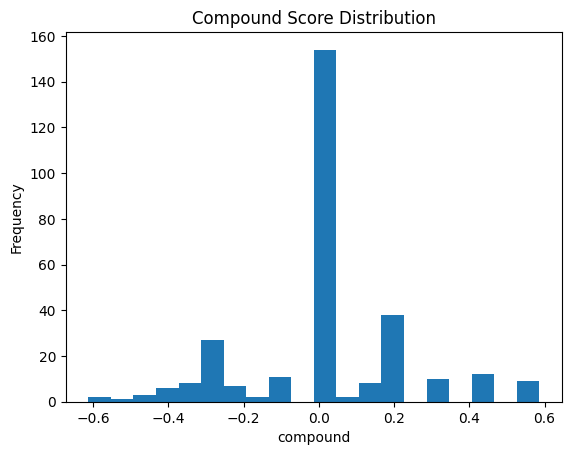

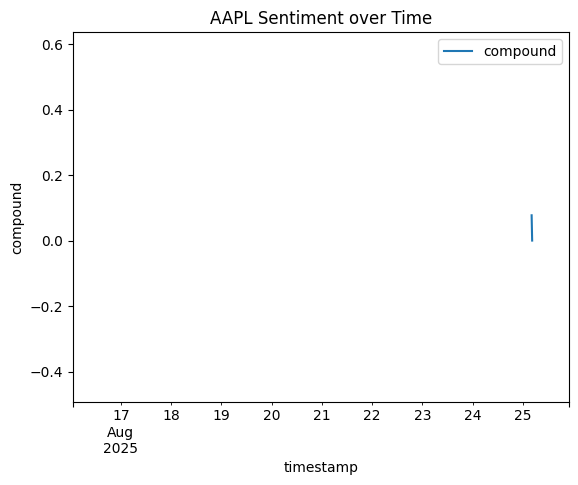

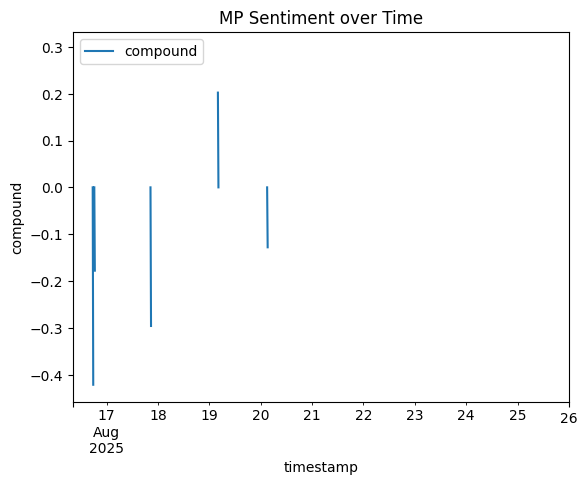

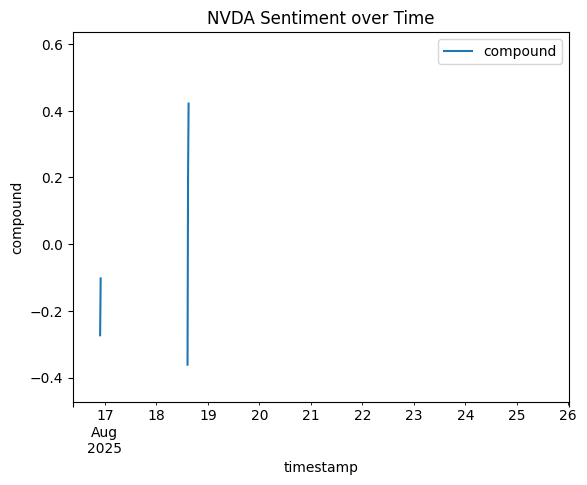

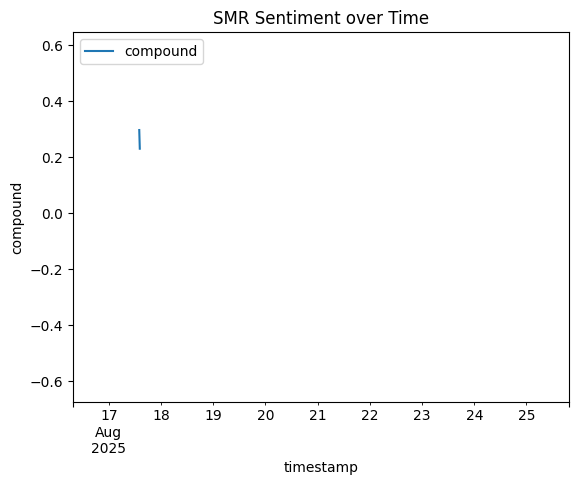

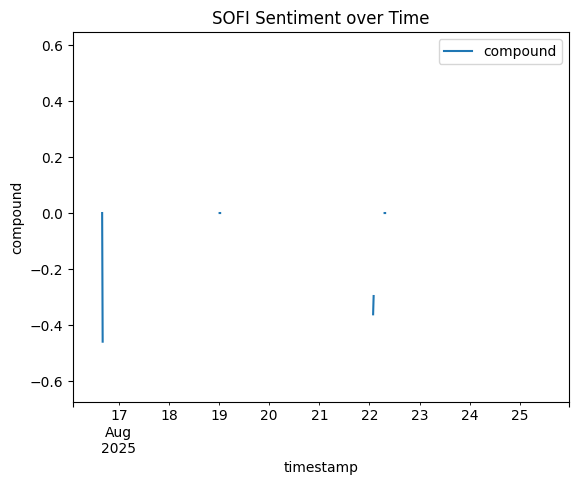

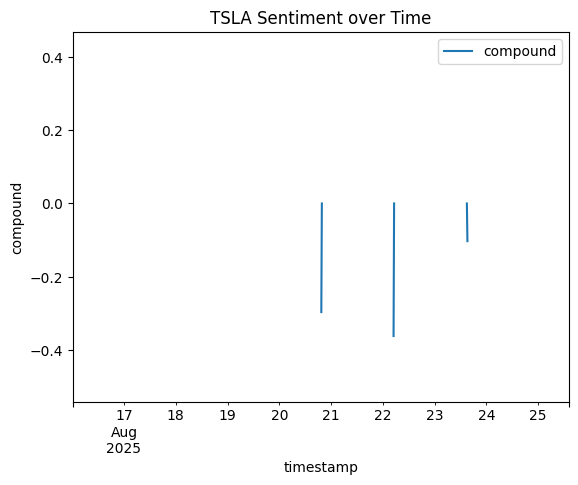

In [9]:
# compound distribution
scored["compound"].plot(kind="hist", bins=20, title="Compound Score Distribution")
plt.xlabel("compound")
plt.show()

# time series by ticker
for t in sent_time["ticker"].unique():
    tmp = sent_time[sent_time["ticker"] == t]
    tmp.plot(x="timestamp", y="compound", title=f"{t} Sentiment over Time")
    plt.ylabel("compound")
    plt.show()

## Save Processed Data

In [ ]:
scored.to_csv(OUT, index=False)
OUT

PosixPath('../data/processed/sample_texts_scored.csv')